In [ ]:
# Install kagglehub (if not already installed)
!pip install -q kagglehub

# Upload kaggle.json (from your Kaggle account)
from google.colab import files
files.upload()  # Upload kaggle.json

# Setup Kaggle API key
import os
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset using kagglehub
import kagglehub
path = kagglehub.dataset_download("angelolmg/tilda-400-64x64-patches")
print("Path to dataset files:", path)


Saving kaggle.json to kaggle.json
Path to dataset files: /kaggle/input/tilda-400-64x64-patches


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/tilda-400-64x64-patches/good/189_patch4-7.png
/kaggle/input/tilda-400-64x64-patches/good/255_patch0-1.png
/kaggle/input/tilda-400-64x64-patches/good/107_patch1-5.png
/kaggle/input/tilda-400-64x64-patches/good/013_patch0-1.png
/kaggle/input/tilda-400-64x64-patches/good/277_patch3-7.png
/kaggle/input/tilda-400-64x64-patches/good/041_patch2-4.png
/kaggle/input/tilda-400-64x64-patches/good/374_patch7-7.png
/kaggle/input/tilda-400-64x64-patches/good/054_patch5-1.png
/kaggle/input/tilda-400-64x64-patches/good/145_patch0-0.png
/kaggle/input/tilda-400-64x64-patches/good/173_patch1-0.png
/kaggle/input/tilda-400-64x64-patches/good/068_patch3-4.png
/kaggle/input/tilda-400-64x64-patches/good/374_patch7-2.png
/kaggle/input/tilda-400-64x64-patches/good/237_patch6-1.png
/kaggle/input/tilda-400-64x64-patches/good/223_patch2-1.png
/kaggle/input/tilda-400-64x64-patches/good/204_patch3-0.png
/kaggle/input/tilda-400-64x64-patches/good/198_pa

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [ ]:
data_dir = '/kaggle/input/tilda-400-64x64-patches'
img_size = (64, 64)
batch_size = 32
num_classes = 5
class_names = ['good', 'hole', 'objects', 'oil spot', 'thread error']

In [ ]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        loss = -y_true * alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

In [ ]:
def build_efficientnet():
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
def train_and_evaluate_model(train_size, test_size, optimizer, optimizer_name):
    print(f"\nTraining with optimizer: {optimizer_name}, train size: {train_size*100}%, test size: {test_size*100}%")

    # Define ImageDataGenerator
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=1 - train_size
    )

    # Train and Validation Generators
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weights_dict = dict(enumerate(class_weights))

    # Build and compile model with specified optimizer
    model = build_efficientnet()
    model.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        class_weight=class_weights_dict
    )

    # Save the model
    model_path = f"/kaggle/working/efficientnet_{optimizer_name}_{int(train_size*100)}_{int(test_size*100)}.h5"
    model.save(model_path)
    print(f"Model saved to: {model_path}")

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_generator)
    print(f"Accuracy: {val_accuracy:.4f}, Loss: {val_loss:.4f}")

    # Confusion Matrix
    val_generator.reset()
    predictions = model.predict(val_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())

    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix ({optimizer_name}, Train {train_size*100}%, Test {test_size*100}%)')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Plot Training History
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
optimizers = {
    'Adam': tf.keras.optimizers.Adam(learning_rate=1e-4),
    'SGD': tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    'AdamW': tf.keras.optimizers.AdamW(learning_rate=1e-4)
}


Training with optimizer: Adam, train size: 90.0%, test size: 10.0%
Found 23044 images belonging to 5 classes.
Found 2556 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 730s 912ms/step - accuracy: 0.6970 - loss: 0.0318 - val_accuracy: 0.9061 - val_loss: 0.0757
Epoch 2/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 648s 899ms/step - accuracy: 0.8737 - loss: 0.0157 - val_accuracy: 0.9061 - val_loss: 0.0369
Epoch 3/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 641s 888ms/step - accuracy: 0.8948 - loss: 0.0135 - val_accuracy: 0.9116 - val_loss: 0.0119
Epoch 4/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 632s 877ms/step - accuracy: 0.9082 - loss: 0.0111 - val_accuracy: 0.3048 - val_loss: 0.0377
Epoch 5/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 689s 886ms/step - accuracy: 0.9145 - loss: 0.0102 - val_accuracy: 0.0513 - val_loss: 0.0654
Epoch 6/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 656s 910ms/step - accuracy: 0.9195 - loss: 0.0098 - val_accuracy: 0.9061 - val_loss: 0.0625
Epoch 7/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 640s 887ms/step - accuracy: 0.9258 - loss: 0.0085 - val_accuracy: 0.0364 - val_loss: 0.0492
Epoch 8/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 704s 919ms/step - accuracy: 0.9237 -

Model saved to: /kaggle/working/efficientnet_Adam_90_10.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step - accuracy: 0.8745 - loss: 0.0154
Accuracy: 0.7981, Loss: 0.0254
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step


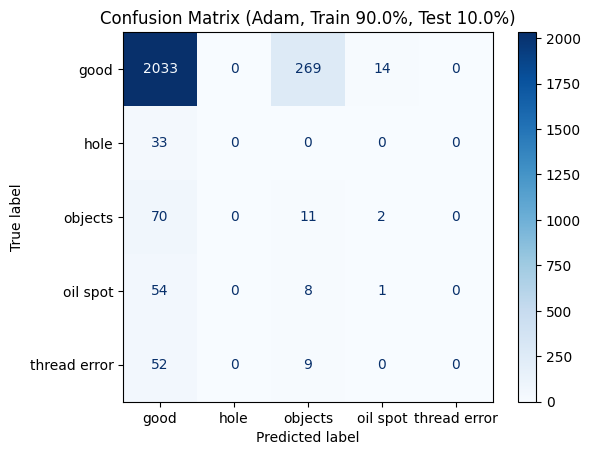

Classification Report:
              precision    recall  f1-score   support

        good       0.91      0.88      0.89      2316
        hole       0.00      0.00      0.00        33
     objects       0.04      0.13      0.06        83
    oil spot       0.06      0.02      0.03        63
thread error       0.00      0.00      0.00        61

    accuracy                           0.80      2556
   macro avg       0.20      0.21      0.19      2556
weighted avg       0.82      0.80      0.81      2556



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


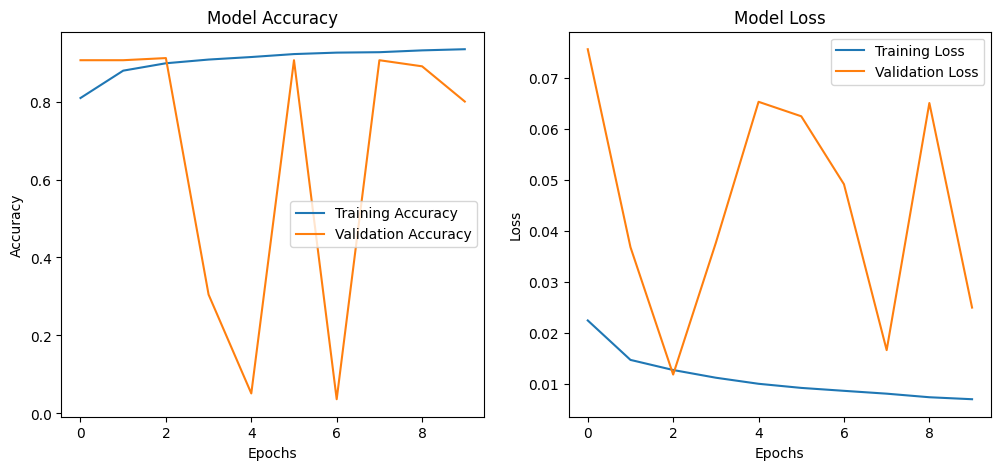


Training with optimizer: SGD, train size: 90.0%, test size: 10.0%
Found 23044 images belonging to 5 classes.
Found 2556 images belonging to 5 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


721/721 ━━━━━━━━━━━━━━━━━━━━ 652s 856ms/step - accuracy: 0.5975 - loss: 0.0397 - val_accuracy: 0.9061 - val_loss: 0.0756
Epoch 2/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 634s 879ms/step - accuracy: 0.8507 - loss: 0.0223 - val_accuracy: 0.9061 - val_loss: 0.0757
Epoch 3/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 615s 853ms/step - accuracy: 0.8607 - loss: 0.0211 - val_accuracy: 0.9061 - val_loss: 0.0739
Epoch 4/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 616s 854ms/step - accuracy: 0.8614 - loss: 0.0196 - val_accuracy: 0.9061 - val_loss: 0.0757
Epoch 5/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 619s 858ms/step - accuracy: 0.8706 - loss: 0.0186 - val_accuracy: 0.9061 - val_loss: 0.0191
Epoch 6/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 672s 931ms/step - accuracy: 0.8713 - loss: 0.0185 - val_accuracy: 0.9061 - val_loss: 0.0757
Epoch 7/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 631s 875ms/step - accuracy: 0.8743 - loss: 0.0172 - val_accuracy: 0.9061 - val_loss: 0.0757
Epoch 8/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 614s 851ms/step - accuracy: 0.8801 - loss: 0.01

Model saved to: /kaggle/working/efficientnet_SGD_90_10.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9936 - loss: 0.0147
Accuracy: 0.9061, Loss: 0.0201
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step


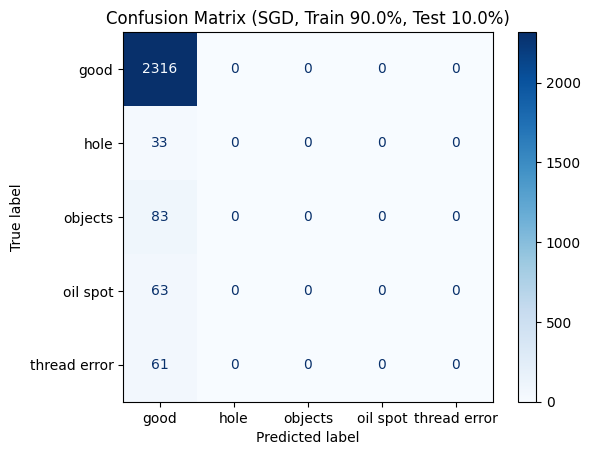

Classification Report:
              precision    recall  f1-score   support

        good       0.91      1.00      0.95      2316
        hole       0.00      0.00      0.00        33
     objects       0.00      0.00      0.00        83
    oil spot       0.00      0.00      0.00        63
thread error       0.00      0.00      0.00        61

    accuracy                           0.91      2556
   macro avg       0.18      0.20      0.19      2556
weighted avg       0.82      0.91      0.86      2556



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


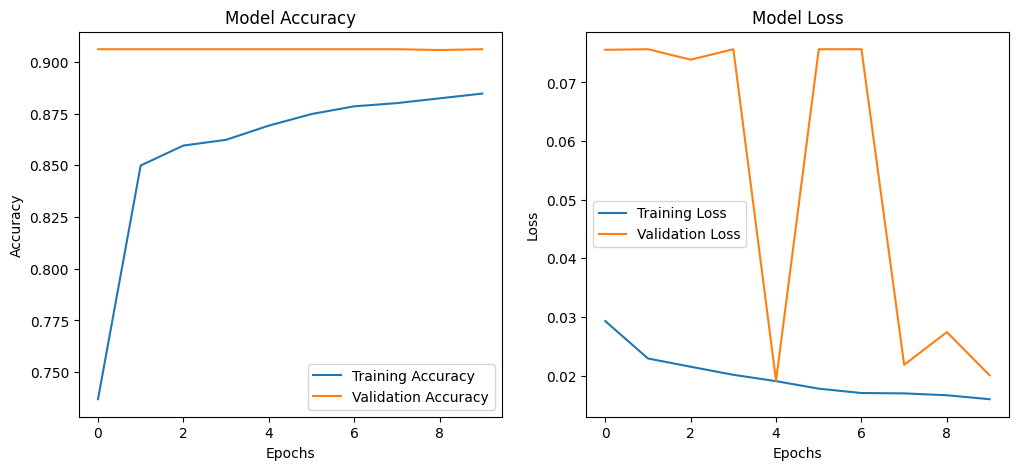


Training with optimizer: RMSprop, train size: 90.0%, test size: 10.0%
Found 23044 images belonging to 5 classes.
Found 2556 images belonging to 5 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


721/721 ━━━━━━━━━━━━━━━━━━━━ 772s 1s/step - accuracy: 0.6728 - loss: 0.0344 - val_accuracy: 0.9061 - val_loss: 0.0757
Epoch 2/10
615/721 ━━━━━━━━━━━━━━━━━━━━ 1:44 982ms/step - accuracy: 0.8774 - loss: 0.0167

In [ ]:
splits = [(0.9, 0.1)]
for train_size, test_size in splits:
    for optimizer_name, optimizer in optimizers.items():
        train_and_evaluate_model(train_size, test_size, optimizer, optimizer_name)

In [ ]:
test_image_paths = [
    '003_patch0-7.png',
    '047_patch3-2.png',
    "000_patch0-0.png"
]

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
model_path = r'/content/efficientnet_AdamW_90_10.h5'  # Update with your model's path
model = load_model(model_path, compile=False)  # compile=False if custom loss used during training

# Define class names
class_names = ['good', 'hole', 'objects', 'oil spot', 'thread error']

# Function to load and preprocess an image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(64, 64))  # Load image and resize
    img_array = img_to_array(img)  # Convert to NumPy array
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Load and preprocess the specified test images
test_image_paths = [
    '003_patch0-7.png',
    '047_patch3-2.png',
    "000_patch0-0.png"
]

test_images = [preprocess_image(path) for path in test_image_paths]

# Make predictions and display the results
for image_path, image in zip(test_image_paths, test_images):
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]

    # Display the image and prediction
    plt.imshow(load_img(image_path))
    plt.title(f'Prediction: {predicted_class_name}')  # Display prediction as title
    plt.axis('off')
    plt.show()# Display the image and prediction
    plt.imshow(load_img(image_path))
    plt.title(f'Prediction: {predicted_class_name}')  # Display prediction as title
    plt.axis('off')
    plt.show()


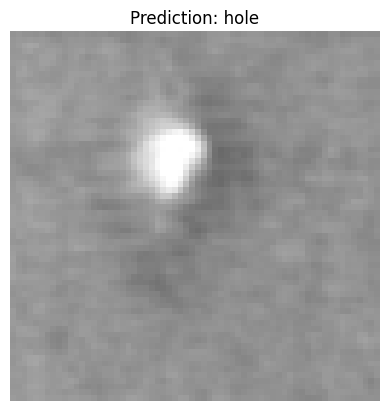

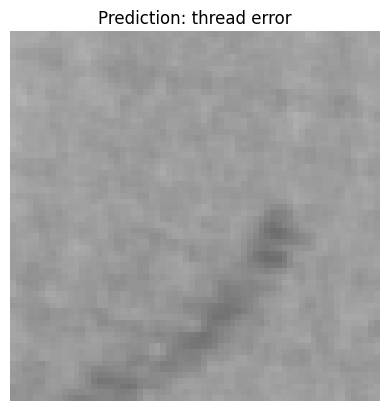

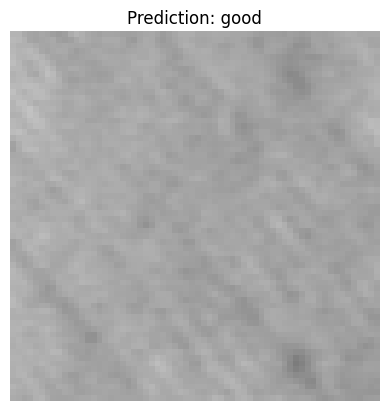

In [ ]:
# Display the image and prediction
for i,image_path  in enumerate(test_image_paths ):
  plt.imshow(load_img(image_path))
  plt.title(f'Prediction: {predicted_class_name[i]}')  # Display prediction as title
  plt.axis('off')
  plt.show()